In [29]:
"""
Numerical estimation of the best CART (depth 1) predictor for y = f(x) + xε
---------------------------------------------------------------------------
Model setup:
    y = f(x) + xε
    where x, ε ~ N(0,1) independent
    and f(x) = 0 if x < 0,  f(x) = x if x ≥ 0

We seek:
    g(x) = a  if x ≤ x0
         = b  if x > x0
that minimizes E[(f(x) - g(x))^2].
MSE_total = 1 + E[(f(x) - g(x))^2]
"""

import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# ---------------------------------------------------------------------
# 1. Define the base functions
# ---------------------------------------------------------------------
phi = norm.pdf      # standard normal pdf
Phi = norm.cdf      # standard normal cdf

def f(x):
    """True nonlinear function f(x)."""
    return np.where(x >= 0, x, 0.0)

# ---------------------------------------------------------------------
# 2. Conditional means a(x0), b(x0)
# ---------------------------------------------------------------------
def a_b(x0):
    """
    Compute the optimal constants a(x0), b(x0) for given split x0.

    a(x0) = E[f(x) | x ≤ x0]
    b(x0) = E[f(x) | x > x0]
    """
    if x0 <= 0:
        a = 0.0
        b = norm.pdf(0) / (1 - Phi(x0))
    else:
        a = (phi(0) - phi(x0)) / Phi(x0)
        b = phi(x0) / (1 - Phi(x0))
    return a, b

# ---------------------------------------------------------------------
# 3. Expected squared loss E[(f(x) - g(x))^2]
# ---------------------------------------------------------------------
def cart_loss(x0):
    """Compute E[(f(x) - g(x))^2] for given x0."""
    a, b = a_b(x0)

    # Integrand function for numerical integration
    def integrand(x):
        gx = np.where(x <= x0, a, b)
        return (f(x) - gx) ** 2 * phi(x)

    # Integrate from -10σ to +10σ (≈ entire normal support)
    val, _ = quad(integrand, -10, 10)
    return val

# ---------------------------------------------------------------------
# 4. Grid search for the optimal split point x0*
# ---------------------------------------------------------------------
grid = np.linspace(-3, 3, 601)           # 401 grid points between -2 and 2
loss_vals = np.array([cart_loss(x0) for x0 in grid])
x0_opt = grid[np.argmin(loss_vals)]

# ---------------------------------------------------------------------
# 5. Compute optimal parameters and total MSE
# ---------------------------------------------------------------------
a_opt, b_opt = a_b(x0_opt)
MSE_cart = 1 + cart_loss(x0_opt)         # total MSE includes Var(y|x)=1

# ---------------------------------------------------------------------
# 6. Print results
# ---------------------------------------------------------------------
print(f"Optimal split point x0* = {x0_opt:.4f}")
print(f"Optimal left constant   a*  = {a_opt:.4f}")
print(f"Optimal right constant  b*  = {b_opt:.4f}")
print(f"Minimum CART MSE        = {MSE_cart:.4f}")


Optimal split point x0* = 0.7000
Optimal left constant   a*  = 0.1144
Optimal right constant  b*  = 1.2905
Minimum CART MSE        = 1.0871


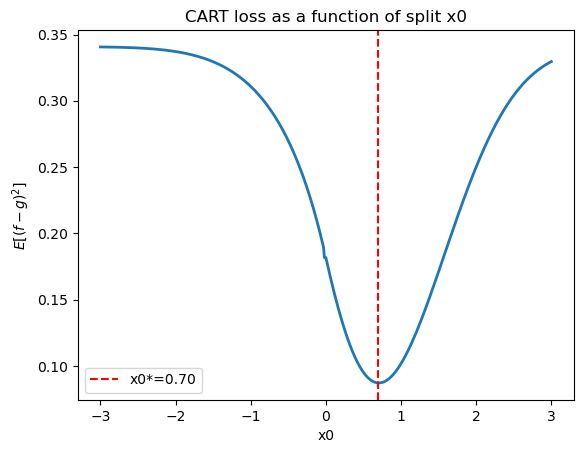

In [30]:
import matplotlib.pyplot as plt

plt.plot(grid, loss_vals, lw=2)
plt.axvline(x0_opt, color='r', ls='--', label=f'x0*={x0_opt:.2f}')
plt.xlabel('x0')
plt.ylabel('$E[(f-g)^2]$')
plt.title('CART loss as a function of split x0')
plt.legend()
plt.show()


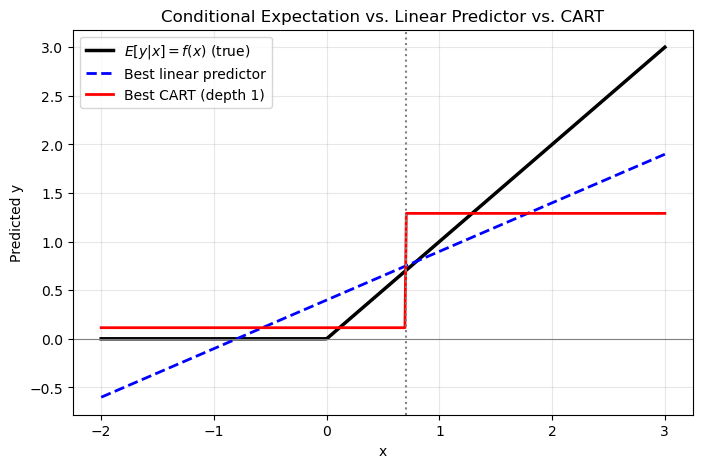

In [31]:
# === 1. Functions ===
def linear_predictor(x):
    """Best linear predictor y* = a + b x."""
    a, b = 1/np.sqrt(2*np.pi), 0.5
    return a + b * x

def cart_predictor(x):
    """Best CART (depth 1) predictor g(x)."""
    return np.where(x <= x0_opt, a_opt, b_opt)

# === 2. Plot ===
x = np.linspace(-2, 3, 400)
plt.figure(figsize=(8,5))

plt.plot(x, f(x), 'k-', lw=2.5, label=r'$E[y|x]=f(x)$ (true)')
plt.plot(x, linear_predictor(x), 'b--', lw=2, label='Best linear predictor')
plt.plot(x, cart_predictor(x), 'r-', lw=2, label='Best CART (depth 1)')
plt.axvline(x0_opt, color='gray', linestyle=':')
plt.axhline(0, color='gray', lw=0.8)
plt.xlabel('x')
plt.ylabel('Predicted y')
plt.title('Conditional Expectation vs. Linear Predictor vs. CART')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
